# PART 1

After creating the docker environement,

The goal of this lab is to create a MNIST Fasion model in pytorch and experiment with the different parameters

Then, we will do the same model but fully quantized and start adapting it for FINN

## Base model creation

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    #transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor with mean and std
]);

# Load the training dataset
train_dataset = datasets.FashionMNIST(
    root='./data',  # Directory to save the dataset
    train=True,  # Load the training set
    download=True,  # Download the dataset if it doesn't exist
    transform=transform  # Apply the defined transformations
);

# Load the test dataset
test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,  # Load the test set
    download=True,
    transform=transform
)

Min :  0.0  /// Max :  0.78039217


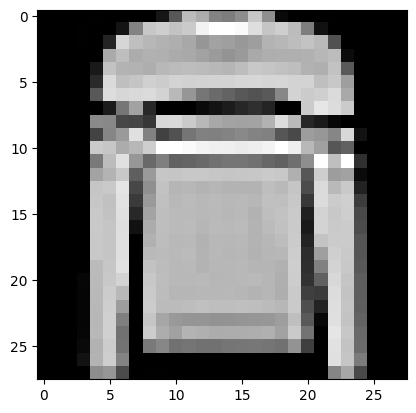

In [3]:
import matplotlib.pyplot as plt
import numpy as np

image, label = train_dataset[5]
image = np.array(image).squeeze()
print("Min : ", np.min(image[0]), " /// Max : ", np.max(image[0]))
# plot the sample

fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

In [4]:
batch_size = 100

# Create a data loader for the training set
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,  # Number of samples per batch
    shuffle=True  # Shuffle the data
)

# Create a data loader for the test set
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False  # No need to shuffle the test data
)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
input_size = 28*28
hidden1 = 64
hidden2 = 64
num_classes = 10

class SimpleFCModel(nn.Module):
    def __init__(self):
        super(SimpleFCModel, self).__init__()
        
        # Define the layers
        self.relu = nn.ReLU()                          # Activation function
        self.fc1 = nn.Linear(input_size, hidden1)  # First hidden layer
        self.fc2 = nn.Linear(hidden1, hidden2) # Second hidden layer
        self.fc3 = nn.Linear(hidden2, num_classes) # Output layer
    
    def forward(self, x):
        # Forward pass through the network
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [7]:
model = SimpleFCModel()
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
model

SimpleFCModel(
  (relu): ReLU()
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [8]:
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = torch.reshape(images, (batch_size, input_size))
        out = model(images)
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/5], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.3506
Epoch [2/5], Loss: 0.3629
Epoch [3/5], Loss: 0.4885
Epoch [4/5], Loss: 0.4001
Epoch [5/5], Loss: 0.2238


In [9]:
# test the model

model.eval()
correct = 0
total = 0
loss_total = 0

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = torch.reshape(images, (batch_size, input_size))
        out = model(images)
        _, predicted = torch.max(out.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print("accuracy =", accuracy)

accuracy = 86.38


# PART 2

This part is about creating a quantized version of the model and adapting it to finn.

In [10]:
import torch
from brevitas.nn import QuantLinear
from brevitas.nn import QuantReLU
from brevitas.nn import QuantIdentity

import torch.nn as nn

brevitas_input_size = 28 * 28
brevitas_hidden1 = 64
brevitas_hidden2 = 64
brevitas_num_classes = 10
weight_bit_width = 4
act_bit_width = 4
dropout_prob = 0.5

#is this model fully quantized or only the wieghts, i shall dig to find out once done !
brevitas_model = nn.Sequential(
    QuantIdentity(bit_width=4),
    QuantLinear(brevitas_input_size, brevitas_hidden1, bias=True, weight_bit_width=weight_bit_width),
    nn.BatchNorm1d(brevitas_hidden1),
    nn.Dropout(0.5),
    QuantReLU(bit_width=act_bit_width),
    QuantLinear(brevitas_hidden1, brevitas_hidden2, bias=True, weight_bit_width=weight_bit_width),
    nn.BatchNorm1d(brevitas_hidden2),
    nn.Dropout(0.5),
    QuantReLU(bit_width=act_bit_width),
    QuantLinear(brevitas_hidden2, brevitas_num_classes, bias=True, weight_bit_width=weight_bit_width),
    QuantReLU(bit_width=act_bit_width)
)

brevitas_model

Sequential(
  (0): QuantIdentity(
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (act_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (fused_activation_quant_proxy): FusedActivationQuantProxy(
        (activation_impl): Identity()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClamp()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
          )
          (scaling_impl): ParameterFromRuntimeStatsScaling(
            (stats_input_view_shape_impl): OverTensorView()
            (stats): _Stats(
              (stats_impl): AbsPercentile()
            )
            (restrict_scaling): _RestrictValue(
              (restrict_value_impl): FloatRestrictValue()
            )
            (clamp_scaling): _ClampValue(
              (clamp_min_ste): Sc

In [11]:
# loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(brevitas_model.parameters(), lr=0.001, betas=(0.9, 0.999))

num_epochs = 5
brevitas_model.train()

for epoch in range(num_epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = torch.reshape(images, (batch_size, input_size))
        out = brevitas_model(images)
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/5], Loss: {loss.item():.4f}')

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1255: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1758.)
  return super(Tensor, self).rename(names)


Epoch [1/5], Loss: 0.6448
Epoch [2/5], Loss: 0.6147
Epoch [3/5], Loss: 0.6063
Epoch [4/5], Loss: 0.5514
Epoch [5/5], Loss: 0.4500


In [12]:
# test the model

brevitas_model.eval()
correct = 0
total = 0
loss_total = 0

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = torch.reshape(images, (batch_size, input_size))
        out = brevitas_model(images)
        _, predicted = torch.max(out.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print("accuracy =", accuracy)

accuracy = 86.38


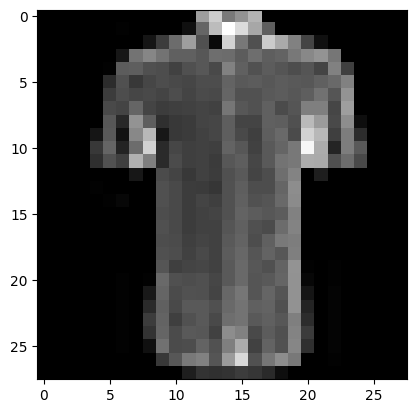

Min :  tensor(0.)  /// Max :  tensor(1.)
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.6196, 0.8039, 0.4784, 0.5725, 0.7020, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0627, 0.3961, 0.7373, 1.0000, 0.8588, 0.6549, 0.3686,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0824,
         0.2392, 0.4235, 0.6196, 0.3137, 0.0353, 0.8235, 0.4706, 0.3137, 0.7961,
         0.6667, 0.5059, 0.2667, 0.0627, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0902, 0.4510, 0.5255,
         0.4510, 0.3765, 0.3765, 0.3412, 0.4314, 0.4235, 0.3608, 0.4314, 0.3686,
         0.388

In [13]:
# lets see what out data look like
fig = plt.figure
plt.imshow(torch.reshape(images[0],(28,28)), cmap='gray')
plt.show()
print("Min : ", torch.min(images[0]), " /// Max : ", torch.max(images[0]))
print(torch.reshape(images[0],(28,28)))
# note : may do the exercice only using uint8

In [15]:
#lets have a quick look at the weights too
print(brevitas_model[1].quant_weight())
#internally, weoght are stored as float 32, here nare ways to visualize actual quantized weights :
print(brevitas_model[1].quant_weight().int())
print(brevitas_model[1].quant_weight().int().dtype)

QuantTensor(value=tensor([[-0.0287, -0.0287, -0.0000,  ...,  0.1148, -0.0287,  0.0000],
        [ 0.0000,  0.0861,  0.0574,  ..., -0.0861, -0.0574,  0.0287],
        [-0.0287, -0.0000,  0.0000,  ..., -0.1148,  0.0287, -0.0574],
        ...,
        [-0.0000, -0.0574, -0.0861,  ...,  0.1148, -0.0287, -0.0574],
        [-0.0574,  0.0574,  0.0861,  ..., -0.0287, -0.0861, -0.0574],
        [-0.0000,  0.0287,  0.0287,  ..., -0.1148,  0.0287, -0.0574]],
       grad_fn=<MulBackward0>), scale=tensor(0.0287, grad_fn=<DivBackward0>), zero_point=tensor(0.), bit_width=tensor(4.), signed_t=tensor(True), training_t=tensor(False))
tensor([[-1, -1,  0,  ...,  4, -1,  0],
        [ 0,  3,  2,  ..., -3, -2,  1],
        [-1,  0,  0,  ..., -4,  1, -2],
        ...,
        [ 0, -2, -3,  ...,  4, -1, -2],
        [-2,  2,  3,  ..., -1, -3, -2],
        [ 0,  1,  1,  ..., -4,  1, -2]], dtype=torch.int8)
torch.int8


In [16]:
# Model wrapper to :
# - make sure the model can rack in bipolar data, we just saw so no need for that
# - add a binary quantizer on the output whith bipolar behavior
# note to myself, may have to rework that output quantizer (or just do no pre/post, also works fine
from brevitas.nn import QuantIdentity


class ModelForExport(nn.Module):
    def __init__(self, my_pretrained_model):
        super(ModelForExport, self).__init__()
        self.pretrained = my_pretrained_model
        """self.qnt_output = QuantIdentity(
            quant_type='binary', 
            scaling_impl_type='const',
            bit_width=1, min_val=-1.0, max_val=1.0)"""
    
    def forward(self, x):
        # here we could insert bipolar preprocessing
        out= self.pretrained(x)
        # outputs as {-1,1}
        """out_final = self.qnt_output(out_original)"""
        return out

model_for_export = ModelForExport(brevitas_model)

In [17]:
# test the model

model_for_export.eval()
correct = 0
total = 0
loss_total = 0

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = torch.reshape(images, (batch_size, input_size))
        out = model_for_export(images)
        _, predicted = torch.max(out.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print("accuracy =", accuracy)

accuracy = 86.38


# PART 3

Exporting the model and visualizing it

In [18]:
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
import numpy as np
import torch

filename = "/tmp/finn_dev_rootmin/LAB_1.onnx"
filename_clean = "/tmp/finn_dev_rootmin/LAB1_clean.onnx"

#Crete a tensor ressembling the input tensor we saw earlier
input_a = np.random.rand(1,28*28).astype(np.float32)
input_a = 2 * input_a - 1 # TODO ERRASE THIS
scale = 1.0
input_t = torch.from_numpy(input_a * scale)

# Export to ONNX
export_qonnx(
    model_for_export, export_path=filename, input_t=input_t
)

# clean-up
qonnx_cleanup(filename, out_file=filename_clean)

In [19]:
from finn.util.visualization import showInNetron

showInNetron(filename)

Serving '/tmp/finn_dev_rootmin/LAB_1.onnx' at http://0.0.0.0:8081


In [ ]:
showInNetron(filename_clean)

In [ ]:
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.core.datatype import DataType

filename_final = "/tmp/finn_dev_rootmin/LAB1_finnonnx.onnx"

# Create a model wrapper, convert to FINN
model = ModelWrapper(filename_clean)
# this is because we saw the input range from -1 to 1 but may have to be reworked
model.set_tensor_datatype(model.graph.input[0].name, DataType["BIPOLAR"])
model = model.transform(ConvertQONNXtoFINN())
model.save(filename_final)

print("Model saved to %s" % filename_final)

In [ ]:
showInNetron(filename_final)